In [1]:
import os

import copy as cp
import numpy as np
import matplotlib.pyplot as plt
import getdist as gd
import getdist.plots as gdp

%matplotlib inline

from lyaemu import likelihood as lyl
from lyaemu import lyman_data as lyd


/share/apps/anaconda/python3.6/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
/home/keir/Software/lya_emulator/lyaemu/SimulationRunner/SimulationRunner/cambpower.py:8: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/share/apps/anaconda/python3.6/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/share/apps/anaconda/python3.6/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/share/apps/an

In [2]:
basedir = '/share/data2/keir/Simulations/nCDM_emulator_512'
emulator_json = 'emulator_params_TDR_u0_original.json'
use_measured_params = True
redshift_dependent_params = True

lyman_data_instance = lyd.BoeraData()
z = lyman_data_instance.redshifts_unique[::-1]


likelihood_instance = lyl.UltraLightAxionLikelihoodClass(basedir, mean_flux='free_high_z', max_z=np.max(z),
                                                         redshifts=z, pixel_resolution_km_s=1., emulator_class='nCDM',
                                                         emulator_json_file=emulator_json,
                                                         use_measured_parameters=use_measured_params,
                                                         redshift_dependent_parameters=redshift_dependent_params,
                                                         data_class='Boera')

likelihood_instance.data_fluxpower = likelihood_instance.lyman_data_flux_power[::-1].flatten()


Beginning to generate emulator at 2020-03-25 16:25:52.170277
k_max_emulated_h_Mpc = 28.093018599498517 0.19952623149688797 4.95 0.33
dpvals = [[0.73805814]
 [0.79181238]
 [0.84556662]
 [0.89932086]
 [0.95307511]
 [1.00682935]
 [1.06058359]
 [1.11433784]
 [1.16809208]
 [1.22184632]]
nuggets = [0.         0.00096758 0.00193515 0.00290273 0.00387031 0.00483788
 0.00580546 0.00677303 0.00774061 0.00870819 0.00967576 0.01064334
 0.01161092 0.01257849 0.01354607 0.01451365 0.01548122 0.0164488
 0.01741637 0.01838395 0.01935153 0.0203191  0.02128668 0.02225426
 0.02322183 0.02418941 0.02515699 0.02612456 0.02709214 0.02805971
 0.02902729 0.02999487 0.03096244 0.03193002 0.0328976  0.03386517
 0.03483275 0.03580033 0.0367679  0.03773548 0.03870306 0.03967063
 0.04063821 0.04160578 0.04257336 0.04354094 0.04450851 0.04547609
 0.04644367 0.04741124]
mean_flux = [[0.27388422 0.36723956 0.45885946]
 [0.24923206 0.34140027 0.43354996]
 [0.22679882 0.31737906 0.40963647]
 [0.20638478 0.29504799 0.38

In [4]:
#Prior function
prior_gaussian_param_names = np.array(['tau0_0', 'tau0_1', 'tau0_2', 'ns', 'As', 'omega_m', 'T_0_z_5.0', 'T_0_z_4.6',
                                      'T_0_z_4.2'])
prior_gaussian_mean = np.array([1., 1., 1., 0.9635, 1.8296e-9, 0.3209, 8022., 7651., 8673.])
prior_gaussian_std = np.array([0.05, 0.05, 0.05, 0.0057, 0.030 * 1.e-9, 0.00001, 3000., 3000., 3000.])
prior_gaussian = lambda params: likelihood_instance.log_gaussian_prior(params, prior_gaussian_param_names,
                                                                       prior_gaussian_mean, prior_gaussian_std)

prior_max_jump_param_names = np.array(['T_0', 'u_0'])
prior_max_jumps = np.array([5000., 10.])
prior_max_jump = lambda params: likelihood_instance.log_redshift_prior(params, prior_max_jump_param_names,
                                                                       prior_max_jumps)

prior_convex_hull_param_names = [['T_0_z_5.0', 'u_0_z_5.0'], ['T_0_z_4.6', 'u_0_z_4.6'], ['T_0_z_4.2', 'u_0_z_4.2']]
prior_convex_hull = lambda params: likelihood_instance.log_convex_hull_prior(params, prior_convex_hull_param_names)

prior_functions = [prior_gaussian, prior_max_jump, prior_convex_hull]


In [5]:
#Test high likelihood
test_params = np.array([0.9635, 1.8296e-9, 0.3209, 8022., 7651., 8673., 1.44, 1.48, 1.45, 4.56, 6.11, 7.24, -19.1])
test_params_mf = np.concatenate((np.array([0.77, 0.78, 0.93]), test_params))
test_params_mf.shape


(16,)

In [ ]:
#Test low likelihood
test_params = np.array([0.975, 1.75e-9, 0.3, 13000., 13000., 13000., 1., 1., 1., 20., 20., 20., -21.])
test_params_mf = np.concatenate((np.ones(3) * 1., test_params))
test_params_mf.shape


In [ ]:
#Test BO functions
log_posterior = likelihood_instance.log_posterior_marginalised_mean_flux(test_params, prior_functions=prior_functions)
print('log posterior marginalised =', log_posterior)


In [ ]:
#Test BO functions [low likelihood]
log_posterior = likelihood_instance.log_posterior_marginalised_mean_flux(test_params, prior_functions=prior_functions)
print('log posterior marginalised =', log_posterior)


In [ ]:
#Test log posterior
log_posterior = likelihood_instance.log_posterior(test_params_mf, prior_functions=prior_functions)
print('log posterior =', log_posterior)


In [ ]:
#Test log posterior [low likelihood]
log_posterior = likelihood_instance.log_posterior(test_params_mf, prior_functions=prior_functions)
print('log posterior =', log_posterior)


In [ ]:
#Test emulator error [marginalised]
emu_err = likelihood_instance._get_emulator_error_averaged_mean_flux(test_params)
print('emulator error marginalised =', emu_err)


In [ ]:
#Test emulator error
emu_k, emu_power, emu_std = likelihood_instance.get_predicted(test_params_mf)


In [ ]:
for i in range(len(emu_k)):
    plt.plot(np.log10(emu_k[i]), np.log10(emu_k[i] * emu_power[i] / np.pi))


In [ ]:
for i in range(len(emu_k)):
    plt.plot(np.log10(emu_k[i]), emu_std[i] / emu_power[i])
    plt.plot(np.log10(emu_k[i]), emu_err[i*emu_k[i].size: (i+1)*emu_k[i].size] / emu_power[i], ls=':')


In [ ]:
#Test exploration term
explore = likelihood_instance._get_GP_UCB_exploration_term(emu_err, 13, nu=0.25)
print('Exploration =', explore)


In [ ]:
likelihood_instance.get_data_covariance(-1).shape


In [ ]:
#Test acquisition function
acquire = likelihood_instance.acquisition_function_GP_UCB_marginalised_mean_flux(test_params, nu=0.25,
                                                                                 prior_functions=prior_functions)
print('Acquisition =', acquire)


In [ ]:
#Test acquisition function
acquire_mf = likelihood_instance.acquisition_function_GP_UCB(test_params_mf, nu=0.25, prior_functions=prior_functions)
print('Acquisition =', acquire_mf)


In [7]:
#Optimise acquisition function
optimise_bounds = [(0.05, 0.95) for i in range(test_params_mf.size)]
optimise_bounds[-1] = (0.05, 1.)
acquire_max = likelihood_instance.optimise_acquisition_function(test_params_mf,
                                                                acquisition_function='GP_UCB',
                                                                optimisation_bounds=optimise_bounds,
                                                                optimisation_method='TNC', nu=0.25,
                                                                prior_functions=prior_functions)


Parameters = [ 7.7500e-01  7.8000e-01  9.3000e-01  9.6350e-01  1.8296e-09  3.2090e-01
  8.0220e+03  7.6510e+03  8.6730e+03  1.4400e+00  1.4800e+00  1.4500e+00
  4.5600e+00  6.1100e+00  7.2400e+00 -1.9100e+01] Exploitation = -362.1722096690994 Exploration = 600.6497106469724 Acquisition = 238.47750097787298
Parameters = [ 7.7500e-01  7.8000e-01  9.3000e-01  9.6350e-01  1.8296e-09  3.2090e-01
  8.0220e+03  7.6510e+03  8.6730e+03  1.4400e+00  1.4800e+00  1.4500e+00
  4.5600e+00  6.1100e+00  7.2400e+00 -1.9100e+01] Exploitation = -362.1722096690994 Exploration = 600.6497106469724 Acquisition = 238.47750097787298
Parameters = [ 7.75000005e-01  7.80000000e-01  9.30000000e-01  9.63500000e-01
  1.82960000e-09  3.20900000e-01  8.02200000e+03  7.65100000e+03
  8.67300000e+03  1.44000000e+00  1.48000000e+00  1.45000000e+00
  4.56000000e+00  6.11000000e+00  7.24000000e+00 -1.91000000e+01] Exploitation = -362.1722138516973 Exploration = 600.6497096711851 Acquisition = 238.47749581948779
Parameters 

Parameters = [ 7.75000000e-01  7.79999993e-01  9.29999999e-01  9.63499998e-01
  1.82960003e-09  3.20900000e-01  8.02199998e+03  7.65099998e+03
  8.67300000e+03  1.44000000e+00  1.48000000e+00  1.45000000e+00
  4.55999989e+00  6.10999985e+00  7.23999999e+00 -1.91000000e+01] Exploitation = -362.1721703934288 Exploration = 600.6496985478657 Acquisition = 238.47752815443687
Parameters = [ 7.75000000e-01  7.79999993e-01  9.29999999e-01  9.63499998e-01
  1.82960001e-09  3.20900000e-01  8.02199998e+03  7.65099998e+03
  8.67300000e+03  1.44000000e+00  1.48000000e+00  1.45000000e+00
  4.55999989e+00  6.10999985e+00  7.23999999e+00 -1.91000000e+01] Exploitation = -362.1721786260231 Exploration = 600.6497152297383 Acquisition = 238.47753660371518
Parameters = [ 7.75000000e-01  7.79999993e-01  9.29999999e-01  9.63499998e-01
  1.82960001e-09  3.20900000e-01  8.02200013e+03  7.65099998e+03
  8.67300000e+03  1.44000000e+00  1.48000000e+00  1.45000000e+00
  4.55999989e+00  6.10999985e+00  7.23999999e+

Parameters = [ 7.75000000e-01  7.79999670e-01  9.29999959e-01  9.63499897e-01
  1.82960062e-09  3.20900002e-01  8.02199923e+03  7.65099913e+03
  8.67300004e+03  1.44000003e+00  1.48000005e+00  1.44999993e+00
  4.55999445e+00  6.10999248e+00  7.23999976e+00 -1.91000002e+01] Exploitation = -362.170218617433 Exploration = 600.6494805403764 Acquisition = 238.4792619229434
Parameters = [ 7.75000000e-01  7.79999670e-01  9.29999959e-01  9.63499897e-01
  1.82960062e-09  3.20900002e-01  8.02199923e+03  7.65099913e+03
  8.67300004e+03  1.44000003e+00  1.48000004e+00  1.44999994e+00
  4.55999445e+00  6.10999248e+00  7.23999976e+00 -1.91000002e+01] Exploitation = -362.17021907075275 Exploration = 600.649480091472 Acquisition = 238.47926102071926
Parameters = [ 7.75000000e-01  7.79999670e-01  9.29999959e-01  9.63499897e-01
  1.82960062e-09  3.20900002e-01  8.02199923e+03  7.65099913e+03
  8.67300004e+03  1.44000003e+00  1.48000004e+00  1.44999993e+00
  4.55999481e+00  6.10999248e+00  7.23999976e+00

Parameters = [ 7.75000000e-01  7.79999761e-01  9.29999970e-01  9.63499925e-01
  1.82960045e-09  3.20899991e-01  8.02199945e+03  7.65099937e+03
  8.67300003e+03  1.44000002e+00  1.48000003e+00  1.44999995e+00
  4.55999598e+00  6.10999455e+00  7.23999982e+00 -1.91000003e+01] Exploitation = -362.1705814374778 Exploration = 600.6492760243817 Acquisition = 238.47869458690394
Parameters = [ 7.75000000e-01  7.79999761e-01  9.29999970e-01  9.63499925e-01
  1.82960045e-09  3.20899991e-01  8.02199945e+03  7.65099937e+03
  8.67300003e+03  1.44000002e+00  1.48000003e+00  1.44999995e+00
  4.55999598e+00  6.10999455e+00  7.23999982e+00 -1.91000003e+01] Exploitation = -362.1705814374778 Exploration = 600.6492760243817 Acquisition = 238.47869458690394
Parameters = [ 7.75000005e-01  7.79999761e-01  9.29999970e-01  9.63499925e-01
  1.82960045e-09  3.20899991e-01  8.02199945e+03  7.65099937e+03
  8.67300003e+03  1.44000002e+00  1.48000003e+00  1.44999995e+00
  4.55999598e+00  6.10999455e+00  7.23999982e+

Parameters = [ 7.75000000e-01  7.79994783e-01  9.29999346e-01  9.63498364e-01
  1.82960981e-09  3.20899814e-01  8.02198790e+03  7.65098630e+03
  8.67300058e+03  1.44000049e+00  1.48000058e+00  1.44999895e+00
  4.55991222e+00  6.10988109e+00  7.23999614e+00 -1.91000064e+01] Exploitation = -362.13675837250855 Exploration = 600.6403239051486 Acquisition = 238.5035655326401
Parameters = [ 7.75000000e-01  7.79994783e-01  9.29999346e-01  9.63498364e-01
  1.82960980e-09  3.20899815e-01  8.02198790e+03  7.65098630e+03
  8.67300058e+03  1.44000049e+00  1.48000058e+00  1.44999895e+00
  4.55991222e+00  6.10988109e+00  7.23999614e+00 -1.91000064e+01] Exploitation = -362.13676788866667 Exploration = 600.6403370995963 Acquisition = 238.50356921092964
Parameters = [ 7.75000000e-01  7.79994783e-01  9.29999346e-01  9.63498364e-01
  1.82960980e-09  3.20899814e-01  8.02198804e+03  7.65098630e+03
  8.67300058e+03  1.44000049e+00  1.48000058e+00  1.44999895e+00
  4.55991222e+00  6.10988109e+00  7.23999614e

Parameters = [ 7.75000000e-01  7.79372475e-01  9.29921376e-01  9.63303249e-01
  1.83077815e-09  3.20877646e-01  8.02054428e+03  7.64935189e+03
  8.67306952e+03  1.44005948e+00  1.48006949e+00  1.44987376e+00
  4.54944175e+00  6.09569790e+00  7.23953558e+00 -1.91007681e+01] Exploitation = -360.42038812130806 Exploration = 599.5248799599074 Acquisition = 239.1044918385993
Parameters = [ 7.75000000e-01  7.79372475e-01  9.29921376e-01  9.63303249e-01
  1.83077815e-09  3.20877646e-01  8.02054428e+03  7.64935189e+03
  8.67306952e+03  1.44005948e+00  1.48006947e+00  1.44987377e+00
  4.54944175e+00  6.09569790e+00  7.23953558e+00 -1.91007681e+01] Exploitation = -360.42038857163874 Exploration = 599.5248795066515 Acquisition = 239.10449093501273
Parameters = [ 7.75000000e-01  7.79372475e-01  9.29921376e-01  9.63303249e-01
  1.83077815e-09  3.20877646e-01  8.02054428e+03  7.64935189e+03
  8.67306952e+03  1.44005948e+00  1.48006947e+00  1.44987376e+00
  4.54944211e+00  6.09569790e+00  7.23953558e

Parameters = [ 7.75000000e-01  7.79683620e-01  9.29960360e-01  9.63400806e-01
  1.83019398e-09  3.20888730e-01  8.02126607e+03  7.65016908e+03
  8.67303505e+03  1.44002999e+00  1.48003503e+00  1.44993636e+00
  4.55467687e+00  6.10278934e+00  7.23976586e+00 -1.91003872e+01] Exploitation = -360.6556190701027 Exploration = 600.081480160248 Acquisition = 239.4258610901453
Parameters = [ 7.75000000e-01  7.79683620e-01  9.29960360e-01  9.63400806e-01
  1.83019398e-09  3.20888730e-01  8.02126607e+03  7.65016908e+03
  8.67303505e+03  1.44002999e+00  1.48003503e+00  1.44993636e+00
  4.55467687e+00  6.10278934e+00  7.23976586e+00 -1.91003872e+01] Exploitation = -360.6556190701027 Exploration = 600.081480160248 Acquisition = 239.4258610901453
Parameters = [ 7.75000005e-01  7.79683620e-01  9.29960360e-01  9.63400806e-01
  1.83019398e-09  3.20888730e-01  8.02126607e+03  7.65016908e+03
  8.67303505e+03  1.44002999e+00  1.48003503e+00  1.44993636e+00
  4.55467687e+00  6.10278934e+00  7.23976586e+00 -

Parameters = [ 7.75000000e-01  7.79683362e-01  9.29960337e-01  9.63400776e-01
  1.83019421e-09  3.20888730e-01  8.02126563e+03  7.65016856e+03
  8.67303497e+03  1.44003000e+00  1.48003505e+00  1.44993634e+00
  4.55467348e+00  6.10278469e+00  7.23976592e+00 -1.91003872e+01] Exploitation = -360.6548837094662 Exploration = 600.0814786620707 Acquisition = 239.4265949526045
Parameters = [ 7.75000000e-01  7.79683362e-01  9.29960337e-01  9.63400776e-01
  1.83019420e-09  3.20888731e-01  8.02126563e+03  7.65016856e+03
  8.67303497e+03  1.44003000e+00  1.48003505e+00  1.44993634e+00
  4.55467348e+00  6.10278469e+00  7.23976592e+00 -1.91003872e+01] Exploitation = -360.65481623515404 Exploration = 600.0814909706434 Acquisition = 239.4266747354893
Parameters = [ 7.75000000e-01  7.79683362e-01  9.29960337e-01  9.63400776e-01
  1.83019420e-09  3.20888730e-01  8.02126577e+03  7.65016856e+03
  8.67303497e+03  1.44003000e+00  1.48003505e+00  1.44993634e+00
  4.55467348e+00  6.10278469e+00  7.23976592e+0

Parameters = [ 7.75000000e-01  7.79679442e-01  9.29960037e-01  9.63400319e-01
  1.83019758e-09  3.20888730e-01  8.02125869e+03  7.65016077e+03
  8.67303446e+03  1.44003030e+00  1.48003543e+00  1.44993615e+00
  4.55462363e+00  6.10271609e+00  7.23976772e+00 -1.91003872e+01] Exploitation = -360.64368686847394 Exploration = 600.0814702437704 Acquisition = 239.43778337529642
Parameters = [ 7.75000000e-01  7.79679442e-01  9.29960037e-01  9.63400319e-01
  1.83019758e-09  3.20888730e-01  8.02125869e+03  7.65016077e+03
  8.67303446e+03  1.44003030e+00  1.48003542e+00  1.44993616e+00
  4.55462363e+00  6.10271609e+00  7.23976772e+00 -1.91003872e+01] Exploitation = -360.643687320751 Exploration = 600.0814697925954 Acquisition = 239.4377824718444
Parameters = [ 7.75000000e-01  7.79679442e-01  9.29960037e-01  9.63400319e-01
  1.83019758e-09  3.20888730e-01  8.02125869e+03  7.65016077e+03
  8.67303446e+03  1.44003030e+00  1.48003542e+00  1.44993615e+00
  4.55462399e+00  6.10271609e+00  7.23976772e+0

Parameters = [ 7.75000000e-01  7.75000000e-01  9.29578238e-01  9.62853893e-01
  1.83420032e-09  3.20888791e-01  8.01303890e+03  7.64081829e+03
  8.67210326e+03  1.44037390e+00  1.48046822e+00  1.44970094e+00
  4.49436527e+00  6.01992610e+00  7.24149132e+00 -1.91003850e+01] Exploitation = -347.61123533723384 Exploration = 600.1115413771946 Acquisition = 252.50030603996078
Parameters = [ 7.75000000e-01  7.75000000e-01  9.29578238e-01  9.62853893e-01
  1.83420032e-09  3.20888791e-01  8.01303890e+03  7.64081829e+03
  8.67210326e+03  1.44037390e+00  1.48046822e+00  1.44970094e+00
  4.49436527e+00  6.01992610e+00  7.24149132e+00 -1.91003850e+01] Exploitation = -347.61123533723384 Exploration = 600.1115413771946 Acquisition = 252.50030603996078
Parameters = [ 7.75000005e-01  7.75000000e-01  9.29578238e-01  9.62853893e-01
  1.83420032e-09  3.20888791e-01  8.01303890e+03  7.64081829e+03
  8.67210326e+03  1.44037390e+00  1.48046822e+00  1.44970094e+00
  4.49436527e+00  6.01992610e+00  7.24149132

Parameters = [ 7.75000000e-01  7.75000000e-01  9.29578238e-01  9.62853893e-01
  1.83420033e-09  3.20888791e-01  8.01303890e+03  7.64081829e+03
  8.67210326e+03  1.44037390e+00  1.48046822e+00  1.44970094e+00
  4.49436527e+00  6.01992610e+00  7.24149132e+00 -1.91003850e+01] Exploitation = -347.6112369159232 Exploration = 600.1115483219502 Acquisition = 252.50031140602698
Parameters = [ 7.75000000e-01  7.75000000e-01  9.29578238e-01  9.62853893e-01
  1.83420032e-09  3.20888792e-01  8.01303890e+03  7.64081829e+03
  8.67210326e+03  1.44037390e+00  1.48046822e+00  1.44970094e+00
  4.49436527e+00  6.01992610e+00  7.24149132e+00 -1.91003850e+01] Exploitation = -347.61117125394657 Exploration = 600.1115581997922 Acquisition = 252.5003869458456
Parameters = [ 7.75000000e-01  7.75000000e-01  9.29578238e-01  9.62853893e-01
  1.83420032e-09  3.20888791e-01  8.01303905e+03  7.64081829e+03
  8.67210326e+03  1.44037390e+00  1.48046822e+00  1.44970094e+00
  4.49436527e+00  6.01992610e+00  7.24149132e+

Parameters = [ 7.75000000e-01  7.75000000e-01  9.29578228e-01  9.62853872e-01
  1.83420043e-09  3.20888791e-01  8.01303235e+03  7.64081412e+03
  8.67210327e+03  1.44037404e+00  1.48046839e+00  1.44970088e+00
  4.49436226e+00  6.01991452e+00  7.24149126e+00 -1.91003850e+01] Exploitation = -347.61087608676695 Exploration = 600.1115299638071 Acquisition = 252.50065387704018
Parameters = [ 7.75000000e-01  7.75000000e-01  9.29578228e-01  9.62853872e-01
  1.83420043e-09  3.20888791e-01  8.01303235e+03  7.64081412e+03
  8.67210327e+03  1.44037404e+00  1.48046838e+00  1.44970089e+00
  4.49436226e+00  6.01991452e+00  7.24149126e+00 -1.91003850e+01] Exploitation = -347.61087653870703 Exploration = 600.111529491409 Acquisition = 252.50065295270196
Parameters = [ 7.75000000e-01  7.75000000e-01  9.29578228e-01  9.62853872e-01
  1.83420043e-09  3.20888791e-01  8.01303235e+03  7.64081412e+03
  8.67210327e+03  1.44037404e+00  1.48046838e+00  1.44970088e+00
  4.49436263e+00  6.01991452e+00  7.24149126e

Parameters = [ 7.75000000e-01  7.75000000e-01  9.29578189e-01  9.62853786e-01
  1.83420092e-09  3.20888791e-01  8.01300551e+03  7.64079708e+03
  8.67210331e+03  1.44037463e+00  1.48046900e+00  1.44970063e+00
  4.49434990e+00  6.01986706e+00  7.24149100e+00 -1.91003851e+01] Exploitation = -347.60939477917844 Exploration = 600.111478632133 Acquisition = 252.5020838529545
Parameters = [ 7.75000000e-01  7.75000000e-01  9.29578189e-01  9.62853786e-01
  1.83420092e-09  3.20888791e-01  8.01300551e+03  7.64079708e+03
  8.67210331e+03  1.44037463e+00  1.48046900e+00  1.44970063e+00
  4.49434990e+00  6.01986706e+00  7.24149100e+00 -1.91003851e+01] Exploitation = -347.60939477917844 Exploration = 600.111478632133 Acquisition = 252.5020838529545
Parameters = [ 7.75000005e-01  7.75000000e-01  9.29578189e-01  9.62853786e-01
  1.83420092e-09  3.20888791e-01  8.01300551e+03  7.64079708e+03
  8.67210331e+03  1.44037463e+00  1.48046900e+00  1.44970063e+00
  4.49434990e+00  6.01986706e+00  7.24149100e+00

Parameters = [ 7.75000000e-01  7.75000000e-01  9.29577182e-01  9.62851558e-01
  1.83421346e-09  3.20888788e-01  8.01230987e+03  7.64035521e+03
  8.67210445e+03  1.44038984e+00  1.48048525e+00  1.44969421e+00
  4.49402966e+00  6.01863704e+00  7.24148436e+00 -1.91003852e+01] Exploitation = -347.5709913857966 Exploration = 600.1102674868496 Acquisition = 252.53927610105296
Parameters = [ 7.75000000e-01  7.75000000e-01  9.29577182e-01  9.62851558e-01
  1.83421344e-09  3.20888789e-01  8.01230987e+03  7.64035521e+03
  8.67210445e+03  1.44038984e+00  1.48048525e+00  1.44969421e+00
  4.49402966e+00  6.01863704e+00  7.24148436e+00 -1.91003852e+01] Exploitation = -347.5709253496757 Exploration = 600.1102778543882 Acquisition = 252.5393525047125
Parameters = [ 7.75000000e-01  7.75000000e-01  9.29577182e-01  9.62851558e-01
  1.83421344e-09  3.20888788e-01  8.01231002e+03  7.64035521e+03
  8.67210445e+03  1.44038984e+00  1.48048525e+00  1.44969421e+00
  4.49402966e+00  6.01863704e+00  7.24148436e+0

Parameters = [ 7.75000000e-01  7.75000000e-01  9.29451268e-01  9.62573016e-01
  1.83577917e-09  3.20888389e-01  7.92535467e+03  7.58512152e+03
  8.67224686e+03  1.44229126e+00  1.48251657e+00  1.44889129e+00
  4.45400019e+00  5.86488413e+00  7.24065401e+00 -1.91003989e+01] Exploitation = -342.81070290525184 Exploration = 599.979128236559 Acquisition = 257.1684253313071
Parameters = [ 7.75000000e-01  7.75000000e-01  9.29451268e-01  9.62573016e-01
  1.83577917e-09  3.20888389e-01  7.92535467e+03  7.58512152e+03
  8.67224686e+03  1.44229126e+00  1.48251656e+00  1.44889130e+00
  4.45400019e+00  5.86488413e+00  7.24065401e+00 -1.91003989e+01] Exploitation = -342.8107033444745 Exploration = 599.97912774863 Acquisition = 257.16842440415553
Parameters = [ 7.75000000e-01  7.75000000e-01  9.29451268e-01  9.62573016e-01
  1.83577917e-09  3.20888389e-01  7.92535467e+03  7.58512152e+03
  8.67224686e+03  1.44229126e+00  1.48251656e+00  1.44889129e+00
  4.45400056e+00  5.86488413e+00  7.24065401e+00 

Parameters = [ 7.75000000e-01  7.75000000e-01  9.27285144e-01  9.57781187e-01
  1.86271468e-09  3.20881526e-01  6.42944285e+03  6.63492263e+03
  8.67469670e+03  1.47500197e+00  1.51746153e+00  1.43507859e+00
  3.76536338e+00  3.21983473e+00  7.22636923e+00 -1.91006347e+01] Exploitation = -273.39126323474784 Exploration = 605.3294659748803 Acquisition = 331.9382027401325
Parameters = [ 7.75000000e-01  7.75000000e-01  9.27285144e-01  9.57781187e-01
  1.86271468e-09  3.20881526e-01  6.42944285e+03  6.63492263e+03
  8.67469670e+03  1.47500197e+00  1.51746153e+00  1.43507859e+00
  3.76536338e+00  3.21983473e+00  7.22636923e+00 -1.91006347e+01] Exploitation = -273.39126323474784 Exploration = 605.3294659748803 Acquisition = 331.9382027401325
Parameters = [ 7.75000005e-01  7.75000000e-01  9.27285144e-01  9.57781187e-01
  1.86271468e-09  3.20881526e-01  6.42944285e+03  6.63492263e+03
  8.67469670e+03  1.47500197e+00  1.51746153e+00  1.43507859e+00
  3.76536338e+00  3.21983473e+00  7.22636923e+

Parameters = [ 7.75000000e-01  7.75000000e-01  9.27285144e-01  9.57781187e-01
  1.86271469e-09  3.20881526e-01  6.42944285e+03  6.63492263e+03
  8.67469670e+03  1.47500197e+00  1.51746153e+00  1.43507859e+00
  3.76536338e+00  3.21983473e+00  7.22636923e+00 -1.91006347e+01] Exploitation = -273.39126434649256 Exploration = 605.3294724494936 Acquisition = 331.938208103001
Parameters = [ 7.75000000e-01  7.75000000e-01  9.27285144e-01  9.57781187e-01
  1.86271468e-09  3.20881526e-01  6.42944285e+03  6.63492263e+03
  8.67469670e+03  1.47500197e+00  1.51746153e+00  1.43507859e+00
  3.76536338e+00  3.21983473e+00  7.22636923e+00 -1.91006347e+01] Exploitation = -273.3911424370562 Exploration = 605.3294876956951 Acquisition = 331.9383452586389
Parameters = [ 7.75000000e-01  7.75000000e-01  9.27285144e-01  9.57781187e-01
  1.86271468e-09  3.20881526e-01  6.42944299e+03  6.63492263e+03
  8.67469670e+03  1.47500197e+00  1.51746153e+00  1.43507859e+00
  3.76536338e+00  3.21983473e+00  7.22636923e+00

Parameters = [ 7.75000000e-01  7.75000000e-01  9.27285144e-01  9.57781187e-01
  1.86271468e-09  3.20881526e-01  6.42944285e+03  6.63492263e+03
  8.67469670e+03  1.47500197e+00  1.51746155e+00  1.43507859e+00
  3.76536338e+00  3.21983473e+00  7.22636923e+00 -1.91006347e+01] Exploitation = -273.39126094114386 Exploration = 605.3294705718041 Acquisition = 331.93820963066025
Parameters = [ 7.75000000e-01  7.75000000e-01  9.27285144e-01  9.57781187e-01
  1.86271468e-09  3.20881526e-01  6.42944285e+03  6.63492263e+03
  8.67469670e+03  1.47500197e+00  1.51746153e+00  1.43507860e+00
  3.76536338e+00  3.21983473e+00  7.22636923e+00 -1.91006347e+01] Exploitation = -273.39126115632666 Exploration = 605.3294697601933 Acquisition = 331.93820860386666
Parameters = [ 7.75000000e-01  7.75000000e-01  9.27285144e-01  9.57781187e-01
  1.86271468e-09  3.20881526e-01  6.42944285e+03  6.63492263e+03
  8.67469670e+03  1.47500197e+00  1.51746153e+00  1.43507859e+00
  3.76536375e+00  3.21983473e+00  7.22636923

Parameters = [ 7.75000000e-01  7.75000000e-01  9.27285235e-01  9.57781415e-01
  1.86271331e-09  3.20881552e-01  6.42944410e+03  6.63492426e+03
  8.67469662e+03  1.47500193e+00  1.51746146e+00  1.43507873e+00
  3.76537472e+00  3.21983473e+00  7.22636977e+00 -1.91006338e+01] Exploitation = -273.3890558852616 Exploration = 605.330771238052 Acquisition = 331.94171535279037
Parameters = [ 7.75000000e-01  7.75000000e-01  9.27285235e-01  9.57781415e-01
  1.86271331e-09  3.20881552e-01  6.42944410e+03  6.63492426e+03
  8.67469662e+03  1.47500193e+00  1.51746146e+00  1.43507873e+00
  3.76537472e+00  3.21983473e+00  7.22636977e+00 -1.91006338e+01] Exploitation = -273.3890558852616 Exploration = 605.330771238052 Acquisition = 331.94171535279037
Parameters = [ 7.75000005e-01  7.75000000e-01  9.27285235e-01  9.57781415e-01
  1.86271331e-09  3.20881552e-01  6.42944410e+03  6.63492426e+03
  8.67469662e+03  1.47500193e+00  1.51746146e+00  1.43507873e+00
  3.76537472e+00  3.21983473e+00  7.22636977e+00

Parameters = [ 7.75000000e-01  7.75000000e-01  9.27296524e-01  9.57809615e-01
  1.86254417e-09  3.20884763e-01  6.42959936e+03  6.63512530e+03
  8.67468664e+03  1.47499730e+00  1.51745170e+00  1.43509683e+00
  3.76677719e+00  3.21983473e+00  7.22643643e+00 -1.91005235e+01] Exploitation = -273.16867614805034 Exploration = 605.4918066164596 Acquisition = 332.32313046840926
Parameters = [ 7.75000000e-01  7.75000000e-01  9.27296524e-01  9.57809615e-01
  1.86254416e-09  3.20884764e-01  6.42959936e+03  6.63512530e+03
  8.67468664e+03  1.47499730e+00  1.51745170e+00  1.43509683e+00
  3.76677719e+00  3.21983473e+00  7.22643643e+00 -1.91005235e+01] Exploitation = -273.168580533933 Exploration = 605.491816089188 Acquisition = 332.323235555255
Parameters = [ 7.75000000e-01  7.75000000e-01  9.27296524e-01  9.57809615e-01
  1.86254416e-09  3.20884763e-01  6.42959950e+03  6.63512530e+03
  8.67468664e+03  1.47499730e+00  1.51745170e+00  1.43509683e+00
  3.76677719e+00  3.21983473e+00  7.22643643e+00 

Parameters = [ 7.75000000e-01  7.75000000e-01  9.34351978e-01  9.75434851e-01
  1.75682502e-09  3.22892077e-01  6.52663422e+03  6.76077861e+03
  8.66844989e+03  1.47210365e+00  1.51135653e+00  1.44640772e+00
  4.64332208e+00  3.21983473e+00  7.26809662e+00 -1.90315507e+01] Exploitation = -20532.566802412715 Exploration = 744.0054594995026 Acquisition = -19788.561342913214
Parameters = [ 7.75000000e-01  7.75000000e-01  9.34351978e-01  9.75434851e-01
  1.75682502e-09  3.22892077e-01  6.52663422e+03  6.76077861e+03
  8.66844971e+03  1.47210366e+00  1.51135653e+00  1.44640772e+00
  4.64332208e+00  3.21983473e+00  7.26809662e+00 -1.90315507e+01] Exploitation = -20532.566802388763 Exploration = 744.005459653946 Acquisition = -19788.561342734818
Parameters = [ 7.75000000e-01  7.75000000e-01  9.34351978e-01  9.75434851e-01
  1.75682502e-09  3.22892077e-01  6.52663422e+03  6.76077861e+03
  8.66844971e+03  1.47210365e+00  1.51135654e+00  1.44640772e+00
  4.64332208e+00  3.21983473e+00  7.2680966

Parameters = [ 7.75000000e-01  7.75000000e-01  9.30824251e-01  9.66622233e-01
  1.80968459e-09  3.21888420e-01  6.47811679e+03  6.69795195e+03
  8.67156818e+03  1.47355047e+00  1.51440412e+00  1.44075228e+00
  4.20504963e+00  3.21983473e+00  7.24726686e+00 -1.90660371e+01] Exploitation = -5305.232967743108 Exploration = 663.8114045607749 Acquisition = -4641.421563182334
Parameters = [ 7.75000000e-01  7.75000000e-01  9.30824251e-01  9.66622233e-01
  1.80968459e-09  3.21888420e-01  6.47811679e+03  6.69795195e+03
  8.67156818e+03  1.47355047e+00  1.51440412e+00  1.44075228e+00
  4.20504963e+00  3.21983473e+00  7.24726652e+00 -1.90660370e+01] Exploitation = -5305.232967587059 Exploration = 663.8114063295184 Acquisition = -4641.421561257541
Parameters = [ 7.75000000e-01  7.75000000e-01  9.29060388e-01  9.62215924e-01
  1.83611437e-09  3.21386592e-01  6.45385807e+03  6.66653863e+03
  8.67312741e+03  1.47427389e+00  1.51592791e+00  1.43792455e+00
  3.98591341e+00  3.21983473e+00  7.23685148e+

Parameters = [ 7.75000000e-01  7.75000000e-01  9.27296529e-01  9.57809615e-01
  1.86254416e-09  3.20884763e-01  6.42959936e+03  6.63512530e+03
  8.67468664e+03  1.47499730e+00  1.51745170e+00  1.43509683e+00
  3.76677719e+00  3.21983473e+00  7.22643643e+00 -1.91005235e+01] Exploitation = -273.1686812673909 Exploration = 605.491790728044 Acquisition = 332.32310946065303
Parameters = [ 7.75000000e-01  7.75000000e-01  9.27296524e-01  9.57809616e-01
  1.86254416e-09  3.20884763e-01  6.42959936e+03  6.63512530e+03
  8.67468664e+03  1.47499730e+00  1.51745170e+00  1.43509683e+00
  3.76677719e+00  3.21983473e+00  7.22643643e+00 -1.91005235e+01] Exploitation = -273.168690809639 Exploration = 605.4917956124162 Acquisition = 332.32310480277727
Parameters = [ 7.75000000e-01  7.75000000e-01  9.27296524e-01  9.57809615e-01
  1.86254417e-09  3.20884763e-01  6.42959936e+03  6.63512530e+03
  8.67468664e+03  1.47499730e+00  1.51745170e+00  1.43509683e+00
  3.76677719e+00  3.21983473e+00  7.22643643e+00

Parameters = [ 7.75000000e-01  7.75000000e-01  9.27315934e-01  9.57857909e-01
  1.86225336e-09  3.20890294e-01  6.42965129e+03  6.63533534e+03
  8.67466967e+03  1.47500495e+00  1.51743583e+00  1.43512784e+00
  3.76873475e+00  3.21983473e+00  7.22655094e+00 -1.91003334e+01] Exploitation = -273.0286968299855 Exploration = 605.7714110469037 Acquisition = 332.7427142169182
Parameters = [ 7.75000000e-01  7.75000000e-01  9.27315934e-01  9.57857909e-01
  1.86225336e-09  3.20890294e-01  6.42965129e+03  6.63533534e+03
  8.67466949e+03  1.47500496e+00  1.51743583e+00  1.43512784e+00
  3.76873475e+00  3.21983473e+00  7.22655094e+00 -1.91003334e+01] Exploitation = -273.02869684373513 Exploration = 605.7714114326259 Acquisition = 332.74271458889075
Parameters = [ 7.75000000e-01  7.75000000e-01  9.27315934e-01  9.57857909e-01
  1.86225336e-09  3.20890294e-01  6.42965129e+03  6.63533534e+03
  8.67466949e+03  1.47500495e+00  1.51743584e+00  1.43512784e+00
  3.76873475e+00  3.21983473e+00  7.22655094e+

Parameters = [ 7.75000000e-01  7.75000000e-01  9.27412982e-01  9.58099380e-01
  1.86079937e-09  3.20917945e-01  6.42991093e+03  6.63638553e+03
  8.67458374e+03  1.47504321e+00  1.51735647e+00  1.43528287e+00
  3.77852254e+00  3.21983473e+00  7.22712382e+00 -1.90993833e+01] Exploitation = -276.9542787929606 Exploration = 607.1759728342575 Acquisition = 330.2216940412969
Parameters = [ 7.75000000e-01  7.75000000e-01  9.27412982e-01  9.58099380e-01
  1.86079937e-09  3.20917945e-01  6.42991093e+03  6.63638553e+03
  8.67458374e+03  1.47504321e+00  1.51735647e+00  1.43528287e+00
  3.77852254e+00  3.21983473e+00  7.22712349e+00 -1.90993833e+01] Exploitation = -276.95427752380095 Exploration = 607.1759763090962 Acquisition = 330.22169878529525
Parameters = [ 7.75000000e-01  7.75000000e-01  9.27364458e-01  9.57978644e-01
  1.86152637e-09  3.20904120e-01  6.42978111e+03  6.63586043e+03
  8.67462662e+03  1.47502408e+00  1.51739615e+00  1.43520535e+00
  3.77362864e+00  3.21983473e+00  7.22683721e+

Parameters = [ 7.75000000e-01  7.75000000e-01  9.27340201e-01  9.57918277e-01
  1.86188986e-09  3.20897207e-01  6.42971620e+03  6.63559789e+03
  8.67464805e+03  1.47501452e+00  1.51741599e+00  1.43516659e+00
  3.77118169e+00  3.21983473e+00  7.22669407e+00 -1.91000959e+01] Exploitation = -273.28735049696826 Exploration = 606.1215364671112 Acquisition = 332.834185970143
Parameters = [ 7.75000000e-01  7.75000000e-01  9.27340196e-01  9.57918278e-01
  1.86188986e-09  3.20897207e-01  6.42971620e+03  6.63559789e+03
  8.67464805e+03  1.47501452e+00  1.51741599e+00  1.43516659e+00
  3.77118169e+00  3.21983473e+00  7.22669407e+00 -1.91000959e+01] Exploitation = -273.28736013359946 Exploration = 606.1215413801173 Acquisition = 332.8341812465178
Parameters = [ 7.75000000e-01  7.75000000e-01  9.27340196e-01  9.57918277e-01
  1.86188988e-09  3.20897207e-01  6.42971620e+03  6.63559789e+03
  8.67464805e+03  1.47501452e+00  1.51741599e+00  1.43516659e+00
  3.77118169e+00  3.21983473e+00  7.22669407e+0

Parameters = [ 7.75000000e-01  7.75000000e-01  9.27340196e-01  9.57918277e-01
  1.86188986e-09  3.20897207e-01  6.42971620e+03  6.63559789e+03
  8.67464823e+03  1.47501452e+00  1.51741599e+00  1.43516659e+00
  3.77118169e+00  3.21983473e+00  7.22669407e+00 -1.91000959e+01] Exploitation = -273.2873471158336 Exploration = 606.1215413202648 Acquisition = 332.8341942044312
Parameters = [ 7.75000000e-01  7.75000000e-01  9.27340196e-01  9.57918277e-01
  1.86188986e-09  3.20897207e-01  6.42971620e+03  6.63559789e+03
  8.67464805e+03  1.47501453e+00  1.51741599e+00  1.43516659e+00
  3.77118169e+00  3.21983473e+00  7.22669407e+00 -1.91000959e+01] Exploitation = -273.287347129201 Exploration = 606.1215417052235 Acquisition = 332.8341945760225
Parameters = [ 7.75000000e-01  7.75000000e-01  9.27340196e-01  9.57918277e-01
  1.86188986e-09  3.20897207e-01  6.42971620e+03  6.63559789e+03
  8.67464805e+03  1.47501452e+00  1.51741600e+00  1.43516659e+00
  3.77118169e+00  3.21983473e+00  7.22669407e+00 

Parameters = [ 7.75000000e-01  7.75000000e-01  9.27340196e-01  9.57918277e-01
  1.86188986e-09  3.20897207e-01  6.42971620e+03  6.63559789e+03
  8.67464805e+03  1.47501452e+00  1.51741599e+00  1.43516659e+00
  3.77118169e+00  3.21983473e+00  7.22669441e+00 -1.91000959e+01] Exploitation = -273.2873501893459 Exploration = 606.1215364467839 Acquisition = 332.83418625743803
Parameters = [ 7.75000000e-01  7.75000000e-01  9.27340196e-01  9.57918277e-01
  1.86188986e-09  3.20897207e-01  6.42971620e+03  6.63559789e+03
  8.67464805e+03  1.47501452e+00  1.51741599e+00  1.43516659e+00
  3.77118169e+00  3.21983473e+00  7.22669407e+00 -1.91000959e+01] Exploitation = -273.28734599222076 Exploration = 606.1215445843161 Acquisition = 332.83419859209533
Parameters = [ 7.75000000e-01  7.75000000e-01  9.27340196e-01  9.57918277e-01
  1.86188986e-09  3.20897207e-01  6.42971620e+03  6.63559789e+03
  8.67464805e+03  1.47501452e+00  1.51741599e+00  1.43516659e+00
  3.77118169e+00  3.21983473e+00  7.22669407e

Parameters = [ 7.75000000e-01  7.75000000e-01  9.27340200e-01  9.57918274e-01
  1.86188987e-09  3.20897207e-01  6.42971383e+03  6.63559639e+03
  8.67464805e+03  1.47501469e+00  1.51741600e+00  1.43516659e+00
  3.77117668e+00  3.21983473e+00  7.22669407e+00 -1.91000959e+01] Exploitation = -273.2873006232559 Exploration = 606.1215628883627 Acquisition = 332.8342622651069
Parameters = [ 7.75000000e-01  7.75000000e-01  9.27340195e-01  9.57918275e-01
  1.86188987e-09  3.20897207e-01  6.42971383e+03  6.63559639e+03
  8.67464805e+03  1.47501469e+00  1.51741600e+00  1.43516659e+00
  3.77117668e+00  3.21983473e+00  7.22669407e+00 -1.91000959e+01] Exploitation = -273.28731026017607 Exploration = 606.121567801421 Acquisition = 332.8342575412449
Parameters = [ 7.75000000e-01  7.75000000e-01  9.27340195e-01  9.57918274e-01
  1.86188988e-09  3.20897207e-01  6.42971383e+03  6.63559639e+03
  8.67464805e+03  1.47501469e+00  1.51741600e+00  1.43516659e+00
  3.77117668e+00  3.21983473e+00  7.22669407e+00

Parameters = [ 7.75000000e-01  7.75000000e-01  9.27340194e-01  9.57918259e-01
  1.86188989e-09  3.20897207e-01  6.42970200e+03  6.63558890e+03
  8.67464823e+03  1.47501554e+00  1.51741605e+00  1.43516658e+00
  3.77115159e+00  3.21983473e+00  7.22669406e+00 -1.91000959e+01] Exploitation = -273.2870646978274 Exploration = 606.1216731235662 Acquisition = 332.8346084257388
Parameters = [ 7.75000000e-01  7.75000000e-01  9.27340194e-01  9.57918259e-01
  1.86188989e-09  3.20897207e-01  6.42970200e+03  6.63558890e+03
  8.67464805e+03  1.47501555e+00  1.51741605e+00  1.43516658e+00
  3.77115159e+00  3.21983473e+00  7.22669406e+00 -1.91000959e+01] Exploitation = -273.28706471140595 Exploration = 606.1216735085163 Acquisition = 332.8346087971104
Parameters = [ 7.75000000e-01  7.75000000e-01  9.27340194e-01  9.57918259e-01
  1.86188989e-09  3.20897207e-01  6.42970200e+03  6.63558890e+03
  8.67464805e+03  1.47501554e+00  1.51741606e+00  1.43516658e+00
  3.77115159e+00  3.21983473e+00  7.22669406e+0

Parameters = [ 7.75000000e-01  7.75000000e-01  9.27340154e-01  9.57917894e-01
  1.86189053e-09  3.20897207e-01  6.42940629e+03  6.63540170e+03
  8.67464810e+03  1.47503690e+00  1.51741731e+00  1.43516637e+00
  3.77052447e+00  3.21983473e+00  7.22669402e+00 -1.91000959e+01] Exploitation = -273.28120266374975 Exploration = 606.1243850264893 Acquisition = 332.8431823627396
Parameters = [ 7.75000000e-01  7.75000000e-01  9.27340154e-01  9.57917894e-01
  1.86189053e-09  3.20897207e-01  6.42940629e+03  6.63540170e+03
  8.67464810e+03  1.47503690e+00  1.51741731e+00  1.43516637e+00
  3.77052447e+00  3.21983473e+00  7.22669368e+00 -1.91000959e+01] Exploitation = -273.28120075367946 Exploration = 606.1243895328772 Acquisition = 332.84318877919776
Parameters = [ 7.75000000e-01  7.75000000e-01  9.27335171e-01  9.57872187e-01
  1.86197034e-09  3.20897219e-01  6.39244170e+03  6.61200155e+03
  8.67465407e+03  1.47770628e+00  1.51757444e+00  1.43513951e+00
  3.69213478e+00  3.21983473e+00  7.22664694e

Parameters = [ 7.75000000e-01  7.75000000e-01  9.27254324e-01  9.57130617e-01
  1.86326518e-09  3.20897414e-01  5.79270346e+03  6.23234185e+03
  8.67475087e+03  1.52101616e+00  1.52012387e+00  1.43470374e+00
  2.42028785e+00  3.21983473e+00  7.22588853e+00 -1.91000889e+01] Exploitation = -260.6783014118436 Exploration = 613.9705180390451 Acquisition = 353.2922166272015
Parameters = [ 7.75000000e-01  7.75000000e-01  9.27254319e-01  9.57130618e-01
  1.86326518e-09  3.20897414e-01  5.79270346e+03  6.23234185e+03
  8.67475087e+03  1.52101616e+00  1.52012387e+00  1.43470374e+00
  2.42028785e+00  3.21983473e+00  7.22588853e+00 -1.91000889e+01] Exploitation = -260.6783102528552 Exploration = 613.9705227247458 Acquisition = 353.2922124718906
Parameters = [ 7.75000000e-01  7.75000000e-01  9.27254319e-01  9.57130617e-01
  1.86326520e-09  3.20897414e-01  5.79270346e+03  6.23234185e+03
  8.67475087e+03  1.52101616e+00  1.52012387e+00  1.43470374e+00
  2.42028785e+00  3.21983473e+00  7.22588853e+00

Parameters = [ 7.75000000e-01  7.75000000e-01  9.27254319e-01  9.57130617e-01
  1.86326518e-09  3.20897414e-01  5.79270346e+03  6.23234185e+03
  8.67475105e+03  1.52101616e+00  1.52012387e+00  1.43470374e+00
  2.42028785e+00  3.21983473e+00  7.22588853e+00 -1.91000889e+01] Exploitation = -260.67830328422224 Exploration = 613.9705145665749 Acquisition = 353.2922112823527
Parameters = [ 7.75000000e-01  7.75000000e-01  9.27254319e-01  9.57130617e-01
  1.86326518e-09  3.20897414e-01  5.79270346e+03  6.23234185e+03
  8.67475087e+03  1.52101617e+00  1.52012387e+00  1.43470374e+00
  2.42028785e+00  3.21983473e+00  7.22588853e+00 -1.91000889e+01] Exploitation = -260.67830328687745 Exploration = 613.9705152198334 Acquisition = 353.2922119329559
Parameters = [ 7.75000000e-01  7.75000000e-01  9.27254319e-01  9.57130617e-01
  1.86326518e-09  3.20897414e-01  5.79270346e+03  6.23234185e+03
  8.67475087e+03  1.52101616e+00  1.52012388e+00  1.43470374e+00
  2.42028785e+00  3.21983473e+00  7.22588853e+

Parameters = [ 7.75000000e-01  7.75000000e-01  9.27254319e-01  9.57130617e-01
  1.86326518e-09  3.20897414e-01  5.79270346e+03  6.23234185e+03
  8.67475087e+03  1.52101616e+00  1.52012387e+00  1.43470374e+00
  2.42028785e+00  3.21983473e+00  7.22588887e+00 -1.91000889e+01] Exploitation = -260.67830115328974 Exploration = 613.9705180174245 Acquisition = 353.2922168641348
Parameters = [ 7.75000000e-01  7.75000000e-01  9.27254319e-01  9.57130617e-01
  1.86326518e-09  3.20897414e-01  5.79270346e+03  6.23234185e+03
  8.67475087e+03  1.52101616e+00  1.52012387e+00  1.43470374e+00
  2.42028785e+00  3.21983473e+00  7.22588853e+00 -1.91000889e+01] Exploitation = -260.67829965032627 Exploration = 613.9705219450725 Acquisition = 353.29222229474624
Parameters = [ 7.75000000e-01  7.75000000e-01  9.27254319e-01  9.57130617e-01
  1.86326518e-09  3.20897414e-01  5.79270345e+03  6.23234185e+03
  8.67475087e+03  1.52101616e+00  1.52012387e+00  1.43470374e+00
  2.42028785e+00  3.21983473e+00  7.22588853e

Parameters = [ 7.75000000e-01  7.75000000e-01  9.27254324e-01  9.57130617e-01
  1.86326518e-09  3.20897414e-01  5.79270346e+03  6.23234185e+03
  8.67475087e+03  1.52101616e+00  1.52012387e+00  1.43470374e+00
  2.42028785e+00  3.21983473e+00  7.22588853e+00 -1.91000889e+01] Exploitation = -260.6783039919776 Exploration = 613.9705138795039 Acquisition = 353.29220988752627
Parameters = [ 7.75000000e-01  7.75000000e-01  9.27254319e-01  9.57130618e-01
  1.86326518e-09  3.20897414e-01  5.79270346e+03  6.23234185e+03
  8.67475087e+03  1.52101616e+00  1.52012387e+00  1.43470374e+00
  2.42028785e+00  3.21983473e+00  7.22588853e+00 -1.91000889e+01] Exploitation = -260.67831283228213 Exploration = 613.9705185653296 Acquisition = 353.29220573304747
Parameters = [ 7.75000000e-01  7.75000000e-01  9.27254319e-01  9.57130617e-01
  1.86326520e-09  3.20897414e-01  5.79270346e+03  6.23234185e+03
  8.67475087e+03  1.52101616e+00  1.52012387e+00  1.43470374e+00
  2.42028785e+00  3.21983473e+00  7.22588853e

Parameters = [ 7.75000000e-01  7.75000000e-01  9.27254319e-01  9.57130617e-01
  1.86326518e-09  3.20897414e-01  5.79270344e+03  6.23234184e+03
  8.67475105e+03  1.52101616e+00  1.52012387e+00  1.43470374e+00
  2.42028785e+00  3.21983473e+00  7.22588853e+00 -1.91000889e+01] Exploitation = -260.67830050578 Exploration = 613.9705201199395 Acquisition = 353.2922196141595
Parameters = [ 7.75000000e-01  7.75000000e-01  9.27254319e-01  9.57130617e-01
  1.86326518e-09  3.20897414e-01  5.79270344e+03  6.23234184e+03
  8.67475087e+03  1.52101617e+00  1.52012387e+00  1.43470374e+00
  2.42028785e+00  3.21983473e+00  7.22588853e+00 -1.91000889e+01] Exploitation = -260.67830050856355 Exploration = 613.9705207731724 Acquisition = 353.2922202646089
Parameters = [ 7.75000000e-01  7.75000000e-01  9.27254319e-01  9.57130617e-01
  1.86326518e-09  3.20897414e-01  5.79270344e+03  6.23234184e+03
  8.67475087e+03  1.52101616e+00  1.52012388e+00  1.43470374e+00
  2.42028785e+00  3.21983473e+00  7.22588853e+00 

Parameters = [ 7.75000000e-01  7.75000000e-01  9.27254319e-01  9.57130617e-01
  1.86326519e-09  3.20897414e-01  5.79270332e+03  6.23234177e+03
  8.67475087e+03  1.52101618e+00  1.52012389e+00  1.43470374e+00
  2.42028785e+00  3.21983473e+00  7.22588887e+00 -1.91000889e+01] Exploitation = -260.67830162525274 Exploration = 613.970527114622 Acquisition = 353.29222548936923
Parameters = [ 7.75000000e-01  7.75000000e-01  9.27254319e-01  9.57130617e-01
  1.86326519e-09  3.20897414e-01  5.79270332e+03  6.23234177e+03
  8.67475087e+03  1.52101618e+00  1.52012389e+00  1.43470374e+00
  2.42028785e+00  3.21983473e+00  7.22588853e+00 -1.91000889e+01] Exploitation = -260.67830249416215 Exploration = 613.9705272179358 Acquisition = 353.29222472377364
Parameters = [ 7.75000000e-01  7.75000000e-01  9.27254319e-01  9.57130622e-01
  1.86326524e-09  3.20897415e-01  5.79270036e+03  6.23234003e+03
  8.67475088e+03  1.52101663e+00  1.52012434e+00  1.43470370e+00
  2.42028785e+00  3.21983473e+00  7.22588851e

Parameters = [ 7.75000000e-01  7.75000000e-01  9.27254305e-01  9.57131184e-01
  1.86327226e-09  3.20897542e-01  5.79232963e+03  6.23212184e+03
  8.67475174e+03  1.52107303e+00  1.52018114e+00  1.43469986e+00
  2.42028785e+00  3.21983473e+00  7.22588507e+00 -1.91000845e+01] Exploitation = -260.6827148627517 Exploration = 613.9912280984391 Acquisition = 353.3085132356874
Parameters = [ 7.75000000e-01  7.75000000e-01  9.27254300e-01  9.57131185e-01
  1.86327226e-09  3.20897542e-01  5.79232963e+03  6.23212184e+03
  8.67475174e+03  1.52107303e+00  1.52018114e+00  1.43469986e+00
  2.42028785e+00  3.21983473e+00  7.22588507e+00 -1.91000845e+01] Exploitation = -260.6827237040433 Exploration = 613.991232784574 Acquisition = 353.30850908053065
Parameters = [ 7.75000000e-01  7.75000000e-01  9.27254300e-01  9.57131184e-01
  1.86327228e-09  3.20897542e-01  5.79232963e+03  6.23212184e+03
  8.67475174e+03  1.52107303e+00  1.52018114e+00  1.43469986e+00
  2.42028785e+00  3.21983473e+00  7.22588507e+00

Parameters = [ 7.75000000e-01  7.75000000e-01  9.27242807e-01  9.57482396e-01
  1.86766030e-09  3.20977065e-01  5.56062576e+03  6.09575497e+03
  8.67529144e+03  1.55632700e+00  1.55567967e+00  1.43229972e+00
  2.42028785e+00  3.21983473e+00  7.22373934e+00 -1.90973522e+01] Exploitation = -294.9598565856517 Exploration = 627.824666815806 Acquisition = 332.8648102301543
Parameters = [ 7.75000000e-01  7.75000000e-01  9.27242807e-01  9.57482396e-01
  1.86766030e-09  3.20977065e-01  5.56062576e+03  6.09575497e+03
  8.67529126e+03  1.55632701e+00  1.55567967e+00  1.43229972e+00
  2.42028785e+00  3.21983473e+00  7.22373934e+00 -1.90973522e+01] Exploitation = -294.9598565120232 Exploration = 627.8246676679568 Acquisition = 332.8648111559336
Parameters = [ 7.75000000e-01  7.75000000e-01  9.27242807e-01  9.57482396e-01
  1.86766030e-09  3.20977065e-01  5.56062576e+03  6.09575497e+03
  8.67529126e+03  1.55632700e+00  1.55567968e+00  1.43229972e+00
  2.42028785e+00  3.21983473e+00  7.22373934e+00 

Parameters = [ 7.75000000e-01  7.75000000e-01  9.27248554e-01  9.57306790e-01
  1.86546628e-09  3.20937303e-01  5.67647769e+03  6.16393841e+03
  8.67502150e+03  1.53870002e+00  1.53793041e+00  1.43349979e+00
  2.42028785e+00  3.21983473e+00  7.22481254e+00 -1.90987183e+01] Exploitation = -269.9485308049628 Exploration = 620.6547848439682 Acquisition = 350.7062540390054
Parameters = [ 7.75000000e-01  7.75000000e-01  9.27248554e-01  9.57306790e-01
  1.86546628e-09  3.20937303e-01  5.67647769e+03  6.16393841e+03
  8.67502150e+03  1.53870002e+00  1.53793041e+00  1.43349979e+00
  2.42028785e+00  3.21983473e+00  7.22481221e+00 -1.90987183e+01] Exploitation = -269.94852722612853 Exploration = 620.654792090463 Acquisition = 350.7062648643345
Parameters = [ 7.75000000e-01  7.75000000e-01  9.27251427e-01  9.57218987e-01
  1.86436927e-09  3.20917423e-01  5.73440366e+03  6.19803012e+03
  8.67488662e+03  1.52988653e+00  1.52905577e+00  1.43409983e+00
  2.42028785e+00  3.21983473e+00  7.22534864e+00

Parameters = [ 7.75000000e-01  7.75000000e-01  9.27251432e-01  9.57218987e-01
  1.86436927e-09  3.20917423e-01  5.73440366e+03  6.19803012e+03
  8.67488662e+03  1.52988653e+00  1.52905577e+00  1.43409983e+00
  2.42028785e+00  3.21983473e+00  7.22534864e+00 -1.90994014e+01] Exploitation = -263.34731393822557 Exploration = 617.2615863598245 Acquisition = 353.9142724215989
Parameters = [ 7.75000000e-01  7.75000000e-01  9.27251427e-01  9.57218988e-01
  1.86436927e-09  3.20917423e-01  5.73440366e+03  6.19803012e+03
  8.67488662e+03  1.52988653e+00  1.52905577e+00  1.43409983e+00
  2.42028785e+00  3.21983473e+00  7.22534864e+00 -1.90994014e+01] Exploitation = -263.3473228691287 Exploration = 617.261591090795 Acquisition = 353.91426822166636
Parameters = [ 7.75000000e-01  7.75000000e-01  9.27251427e-01  9.57218987e-01
  1.86436928e-09  3.20917423e-01  5.73440366e+03  6.19803012e+03
  8.67488662e+03  1.52988653e+00  1.52905577e+00  1.43409983e+00
  2.42028785e+00  3.21983473e+00  7.22534864e+0

Parameters = [ 7.75000000e-01  7.75000000e-01  9.27251427e-01  9.57218987e-01
  1.86436927e-09  3.20917423e-01  5.73440366e+03  6.19803012e+03
  8.67488680e+03  1.52988653e+00  1.52905577e+00  1.43409983e+00
  2.42028785e+00  3.21983473e+00  7.22534864e+00 -1.90994014e+01] Exploitation = -263.34731263056204 Exploration = 617.2615881033738 Acquisition = 353.91427547281177
Parameters = [ 7.75000000e-01  7.75000000e-01  9.27251427e-01  9.57218987e-01
  1.86436927e-09  3.20917423e-01  5.73440366e+03  6.19803012e+03
  8.67488662e+03  1.52988654e+00  1.52905577e+00  1.43409983e+00
  2.42028785e+00  3.21983473e+00  7.22534864e+00 -1.90994014e+01] Exploitation = -263.3473126142079 Exploration = 617.2615888043257 Acquisition = 353.9142761901178
Parameters = [ 7.75000000e-01  7.75000000e-01  9.27251427e-01  9.57218987e-01
  1.86436927e-09  3.20917423e-01  5.73440366e+03  6.19803012e+03
  8.67488662e+03  1.52988653e+00  1.52905578e+00  1.43409983e+00
  2.42028785e+00  3.21983473e+00  7.22534864e+

Parameters = [ 7.75000000e-01  7.75000000e-01  9.27251427e-01  9.57218987e-01
  1.86436927e-09  3.20917423e-01  5.73440367e+03  6.19803013e+03
  8.67488662e+03  1.52988653e+00  1.52905577e+00  1.43409983e+00
  2.42028785e+00  3.21983473e+00  7.22534897e+00 -1.90994014e+01] Exploitation = -263.3473125351986 Exploration = 617.2615874900694 Acquisition = 353.91427495487073
Parameters = [ 7.75000000e-01  7.75000000e-01  9.27251427e-01  9.57218987e-01
  1.86436927e-09  3.20917423e-01  5.73440367e+03  6.19803013e+03
  8.67488662e+03  1.52988653e+00  1.52905577e+00  1.43409983e+00
  2.42028785e+00  3.21983473e+00  7.22534864e+00 -1.90994014e+01] Exploitation = -263.3473122325106 Exploration = 617.2615894803639 Acquisition = 353.9142772478533
Parameters = [ 7.75000000e-01  7.75000000e-01  9.27251427e-01  9.57218987e-01
  1.86436927e-09  3.20917423e-01  5.73440366e+03  6.19803013e+03
  8.67488662e+03  1.52988653e+00  1.52905577e+00  1.43409983e+00
  2.42028785e+00  3.21983473e+00  7.22534864e+0

Parameters = [ 7.75000000e-01  7.75000000e-01  9.27251432e-01  9.57218987e-01
  1.86436927e-09  3.20917423e-01  5.73440366e+03  6.19803012e+03
  8.67488662e+03  1.52988653e+00  1.52905577e+00  1.43409983e+00
  2.42028785e+00  3.21983473e+00  7.22534864e+00 -1.90994014e+01] Exploitation = -263.34731274721776 Exploration = 617.2615881790691 Acquisition = 353.91427543185137
Parameters = [ 7.75000000e-01  7.75000000e-01  9.27251427e-01  9.57218988e-01
  1.86436927e-09  3.20917423e-01  5.73440366e+03  6.19803012e+03
  8.67488662e+03  1.52988653e+00  1.52905577e+00  1.43409983e+00
  2.42028785e+00  3.21983473e+00  7.22534864e+00 -1.90994014e+01] Exploitation = -263.3473216782114 Exploration = 617.2615929101199 Acquisition = 353.9142712319085
Parameters = [ 7.75000000e-01  7.75000000e-01  9.27251427e-01  9.57218987e-01
  1.86436928e-09  3.20917423e-01  5.73440366e+03  6.19803012e+03
  8.67488662e+03  1.52988653e+00  1.52905577e+00  1.43409983e+00
  2.42028785e+00  3.21983473e+00  7.22534864e+

Parameters = [ 7.75000000e-01  7.75000000e-01  9.27251427e-01  9.57218987e-01
  1.86436927e-09  3.20917423e-01  5.73440366e+03  6.19803012e+03
  8.67488680e+03  1.52988653e+00  1.52905577e+00  1.43409983e+00
  2.42028785e+00  3.21983473e+00  7.22534864e+00 -1.90994014e+01] Exploitation = -263.34731245469413 Exploration = 617.2615881920046 Acquisition = 353.9142757373105
Parameters = [ 7.75000000e-01  7.75000000e-01  9.27251427e-01  9.57218987e-01
  1.86436927e-09  3.20917423e-01  5.73440366e+03  6.19803012e+03
  8.67488662e+03  1.52988654e+00  1.52905577e+00  1.43409983e+00
  2.42028785e+00  3.21983473e+00  7.22534864e+00 -1.90994014e+01] Exploitation = -263.34731243807556 Exploration = 617.2615888929424 Acquisition = 353.91427645486687
Parameters = [ 7.75000000e-01  7.75000000e-01  9.27251427e-01  9.57218987e-01
  1.86436927e-09  3.20917423e-01  5.73440366e+03  6.19803012e+03
  8.67488662e+03  1.52988653e+00  1.52905578e+00  1.43409983e+00
  2.42028785e+00  3.21983473e+00  7.22534864e

In [ ]:
acquire_max


In [ ]:
acquire_max0 = cp.deepcopy(acquire_max)


In [ ]:
acquire_max0


In [ ]:
#Marginalise mean flux
 fun: -394.72107147587747
     jac: array([ 4.33402533e+01, -3.24205530e+02,  2.16144097e+04,  3.26689360e+00,
        5.59946329e+00, -2.06749746e+00, -9.49059540e+01, -1.35267192e+02,
        2.33754122e+01,  2.24580754e+02,  2.96598682e+02,  6.20065634e+00,
        1.99674491e+02])
 message: 'Converged (|x_n-x_(n-1)| ~= 0)'
    nfev: 93
     nit: 6
  status: 2
 success: True
       x: array([0.54330369, 0.58804541, 0.87045623, 0.45045675, 0.43422056,
       0.406574  , 0.70211524, 0.71994382, 0.67016032, 0.05594524,
       0.05575224, 0.17343253, 0.95731355])


In [8]:
acquire_max_params = lyl.map_from_unit_cube(acquire_max.x, likelihood_instance.param_limits)


In [ ]:
acquire_max_params = lyl.map_from_unit_cube(acquire_max.x,
                                            likelihood_instance.param_limits[likelihood_instance.zout.shape[0]:])


In [10]:
print('Maximum of acquisition function =', acquire_max)
print(acquire_max_params)
print('Starting params =', test_params_mf)


Maximum of acquisition function =      fun: -353.914275727603
     jac: array([ 4.55890307e+02,  4.89668190e+02,  2.95751647e+01,  4.49569450e+02,
       -3.77147819e+02,  1.14626398e+04,  1.19608262e+02,  1.13920612e+02,
       -9.70749170e-01, -7.27263853e+01, -7.31309228e+01,  3.79277651e+01,
        2.01726948e+02,  2.63873142e+02,  5.39544658e+00, -3.13192612e+02])
 message: 'Converged (|x_n-x_(n-1)| ~= 0)'
    nfev: 58
     nit: 8
  status: 2
 success: True
       x: array([0.05      , 0.05      , 0.35450285, 0.60230512, 0.51105329,
       0.87024889, 0.30105636, 0.34192525, 0.40767761, 0.75969048,
       0.73606158, 0.66219663, 0.05      , 0.05      , 0.17386334,
       0.96686619])
[ 7.75000000e-01  7.75000000e-01  9.27251427e-01  9.57218987e-01
  1.86436927e-09  3.20917423e-01  5.73440366e+03  6.19803012e+03
  8.67488662e+03  1.52988653e+00  1.52905577e+00  1.43409983e+00
  2.42028785e+00  3.21983473e+00  7.22534864e+00 -1.90994014e+01]
Starting params = [ 7.7000e-01  7.8000e-

In [11]:
#Plot posteriors
def make_plot(chainfile, savefile, true_parameter_values=None, pnames=None, ranges=None, parameter_indices=None):
    """Make a getdist plot"""
    samples = np.loadtxt(chainfile)
    #A_s hack
    #samples = samples[samples[:, 4] > 2.05e-9, :]

    if parameter_indices is not None:
        samples = samples[:, parameter_indices]
        true_parameter_values = true_parameter_values[parameter_indices]
        pnames = pnames[parameter_indices]
        ranges = ranges[parameter_indices]

    ticks = {}
    if pnames is None:
        #Default emulator parameters
        pnames = [r"d\tau_0", r"\tau_0", r"n_s", r"A_\mathrm{P} \times 10^9", r"H_S", r"H_A", r"h"]
        samples[:,3] *= 1e9
        true_parameter_values[3] *= 1e9
        #Ticks we want to show for each parameter
        ticks = {pnames[3]: [1.5, 2.0, 2.5], pnames[4]: [-0.6,-0.3, 0.], pnames[5]: [0.5,0.7,1.0,1.3], pnames[6]: [0.66, 0.70, 0.74]}
    prange = None
    if ranges is not None:
        prange = {pnames[i] : ranges[i] for i in range(len(pnames))}
    posterior_MCsamples = gd.MCSamples(samples=samples, names=pnames, labels=pnames, label='', ranges=prange)

    print("Sim=",savefile)
    #Get and print the confidence limits
    for i in range(len(pnames)):
        strr = pnames[i]+" 1-sigma, 2-sigma: "
        if i == 6:
            for j in (0.32, 0.05):
                strr += str(round(posterior_MCsamples.confidence(i, j, upper=True),5)) + " "
        else:
            for j in (0.16, 1-0.16, 0.025, 1-0.025):
                strr += str(round(posterior_MCsamples.confidence(i, j),5)) + " "
        print(strr)
    subplot_instance = gdp.getSubplotPlotter()
    subplot_instance.triangle_plot([posterior_MCsamples], filled=True)
#     colour_array = np.array(['black', 'red', 'magenta', 'green', 'green', 'purple', 'turquoise', 'gray', 'red', 'blue'])

    for pi in range(samples.shape[1]):
        for pi2 in range(pi + 1):
            #Place horizontal and vertical lines for the true point
            ax = subplot_instance.subplots[pi, pi2]
            ax.yaxis.label.set_size(24)
            ax.xaxis.label.set_size(24)
            if pi == samples.shape[1]-1 and pnames[pi2] in ticks:
                ax.set_xticks(ticks[pnames[pi2]])
            if pi2 == 0 and pnames[pi] in ticks:
                ax.set_yticks(ticks[pnames[pi]])
            ax.axvline(true_parameter_values[pi2], color='gray', ls='--', lw=4)
            if pi2 < pi:
                ax.axhline(true_parameter_values[pi], color='gray', ls='--', lw=4)
#                #Plot the emulator points
#                 if parameter_index > 1:
#                     ax.scatter(simulation_parameters_latin[:, parameter_index2 - 2], simulation_parameters_latin[:, parameter_index - 2], s=54, color=colour_array[-1], marker='+')
#
#     legend_labels = ['+ Initial Latin hypercube']
#     subplot_instance.add_legend(legend_labels, legend_loc='upper right', colored_text=True, figure=True)
    plt.savefig(savefile)

    return subplot_instance


Sim= None
\tau_0(z=4.95) 1-sigma, 2-sigma: 0.79826 0.88238 0.76049 0.917 
\tau_0(z=4.58) 1-sigma, 2-sigma: 0.78506 0.87376 0.75981 0.91642 
\tau_0(z=4.24) 1-sigma, 2-sigma: 1.00011 1.12113 0.92374 1.20171 
n_\mathrm{s} 1-sigma, 2-sigma: 0.94915 0.9545 0.947 0.95709 
A_\mathrm{s} 1-sigma, 2-sigma: 0.0 0.0 0.0 0.0 
\Omega_\mathrm{m} 1-sigma, 2-sigma: 0.32089 0.32091 0.32087 0.32092 
T_0(z=5) 1-sigma, 2-sigma: 7086.97701 9902.79513 
T_0(z=4.6) 1-sigma, 2-sigma: 5440.61601 9229.36144 3884.86618 11419.09622 
T_0(z=4.2) 1-sigma, 2-sigma: 6693.10456 12063.60584 4503.74794 14381.7897 
\gamma(z=5) 1-sigma, 2-sigma: 0.94111 1.40101 0.77517 1.63054 
\gamma(z=4.6) 1-sigma, 2-sigma: 1.09213 1.71249 0.84554 1.79145 
\gamma(z=4.2) 1-sigma, 2-sigma: 1.16299 1.42269 1.01561 1.55037 
u_0(z=5) 1-sigma, 2-sigma: 1.91889 17.97501 1.03487 26.33769 
u_0(z=4.6) 1-sigma, 2-sigma: 7.20063 21.53728 3.83476 27.36127 
u_0(z=4.2) 1-sigma, 2-sigma: 9.35889 22.81833 4.5054 28.7717 
logma 1-sigma, 2-sigma: -19.703 -19

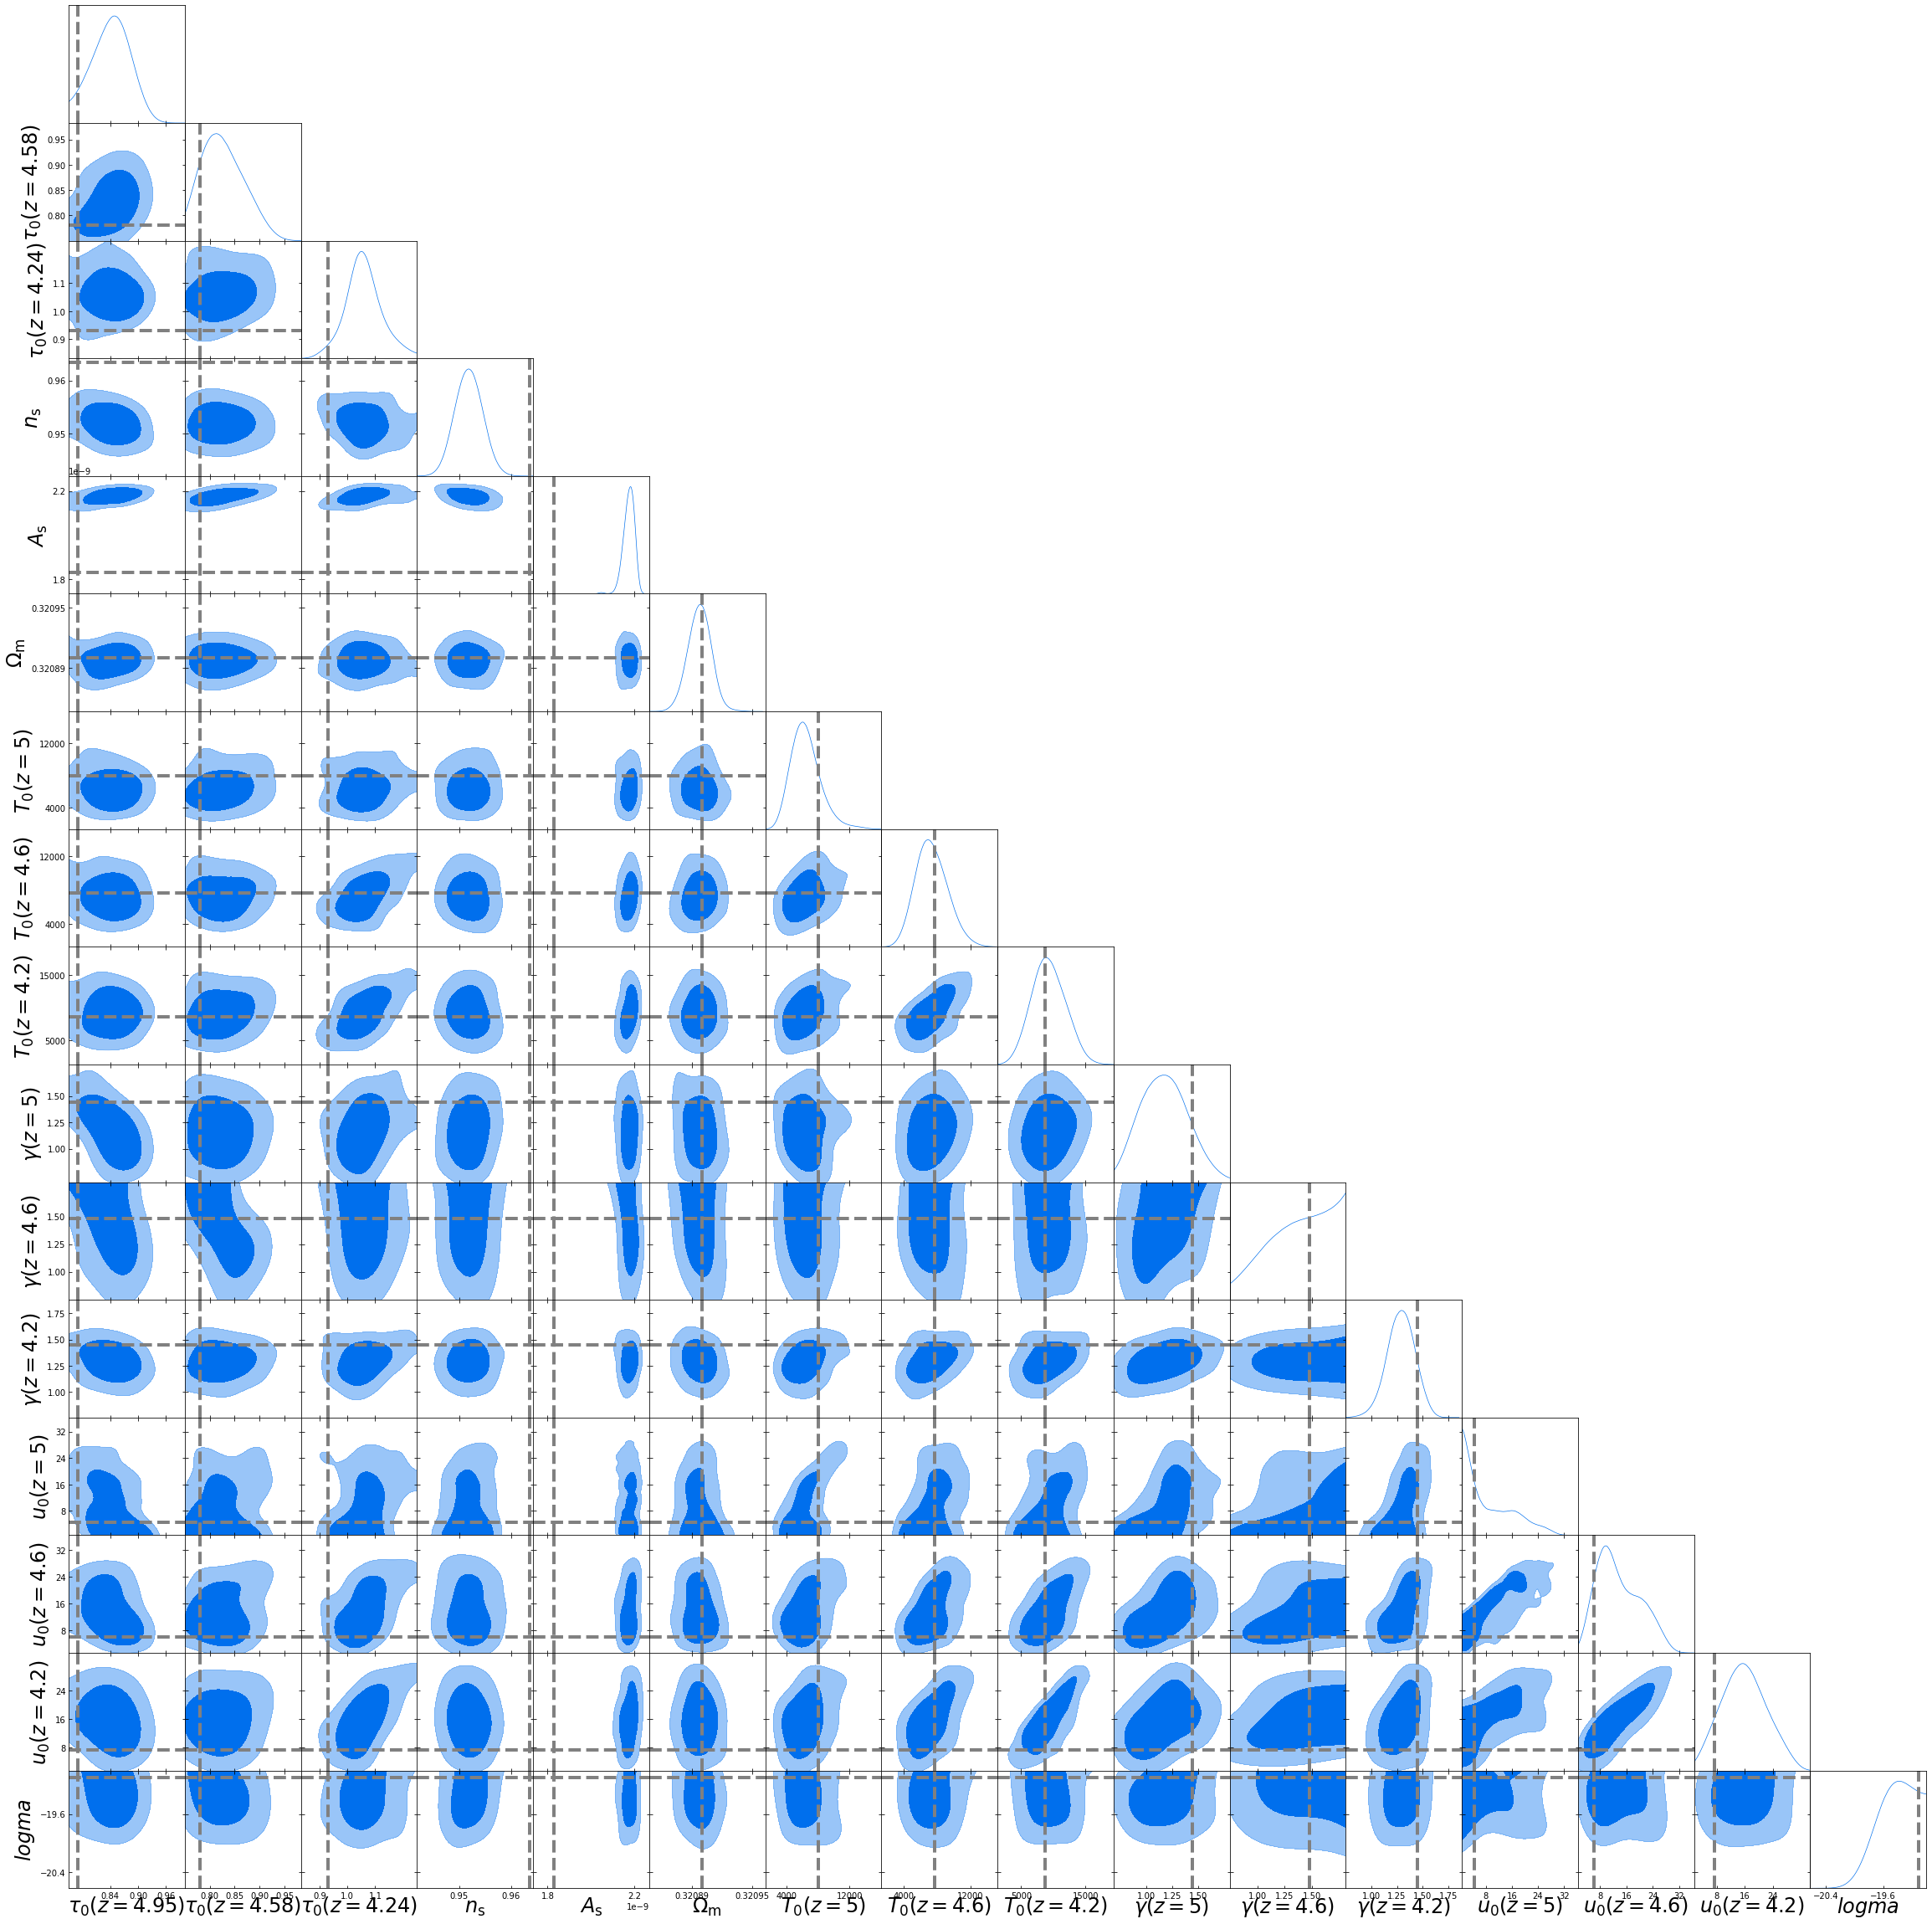

In [12]:
chainfile_root = '/home/keir/Plots/nCDM'
chainfile = 'chain_ns0.964As1.83e-09heat_slope0heat_amp1omega_m0.321alpha0beta1gamma-1z_rei8T_rei2e+04_1_emu50_data_TDR_u0_300_ULA_fit_convex_hull_omega_m_fix_Planck_tau_T0_prior_no_jump_Tu0.txt'
chainfile = os.path.join(chainfile_root, chainfile)

subplot_instance = make_plot(chainfile, None, true_parameter_values=test_params_mf,
          pnames=likelihood_instance.likelihood_parameter_names[:, 1],
          ranges=likelihood_instance.param_limits)


In [14]:
#Plot test points
for a in range(0, test_params_mf.shape[0]):
    for b in range(a + 1):
        ax = subplot_instance.subplots[a, b]
        if b < a:
            ax.scatter(acquire_max_params[b - 0], acquire_max_params[a - 0], s=1000, color='red', marker='+')


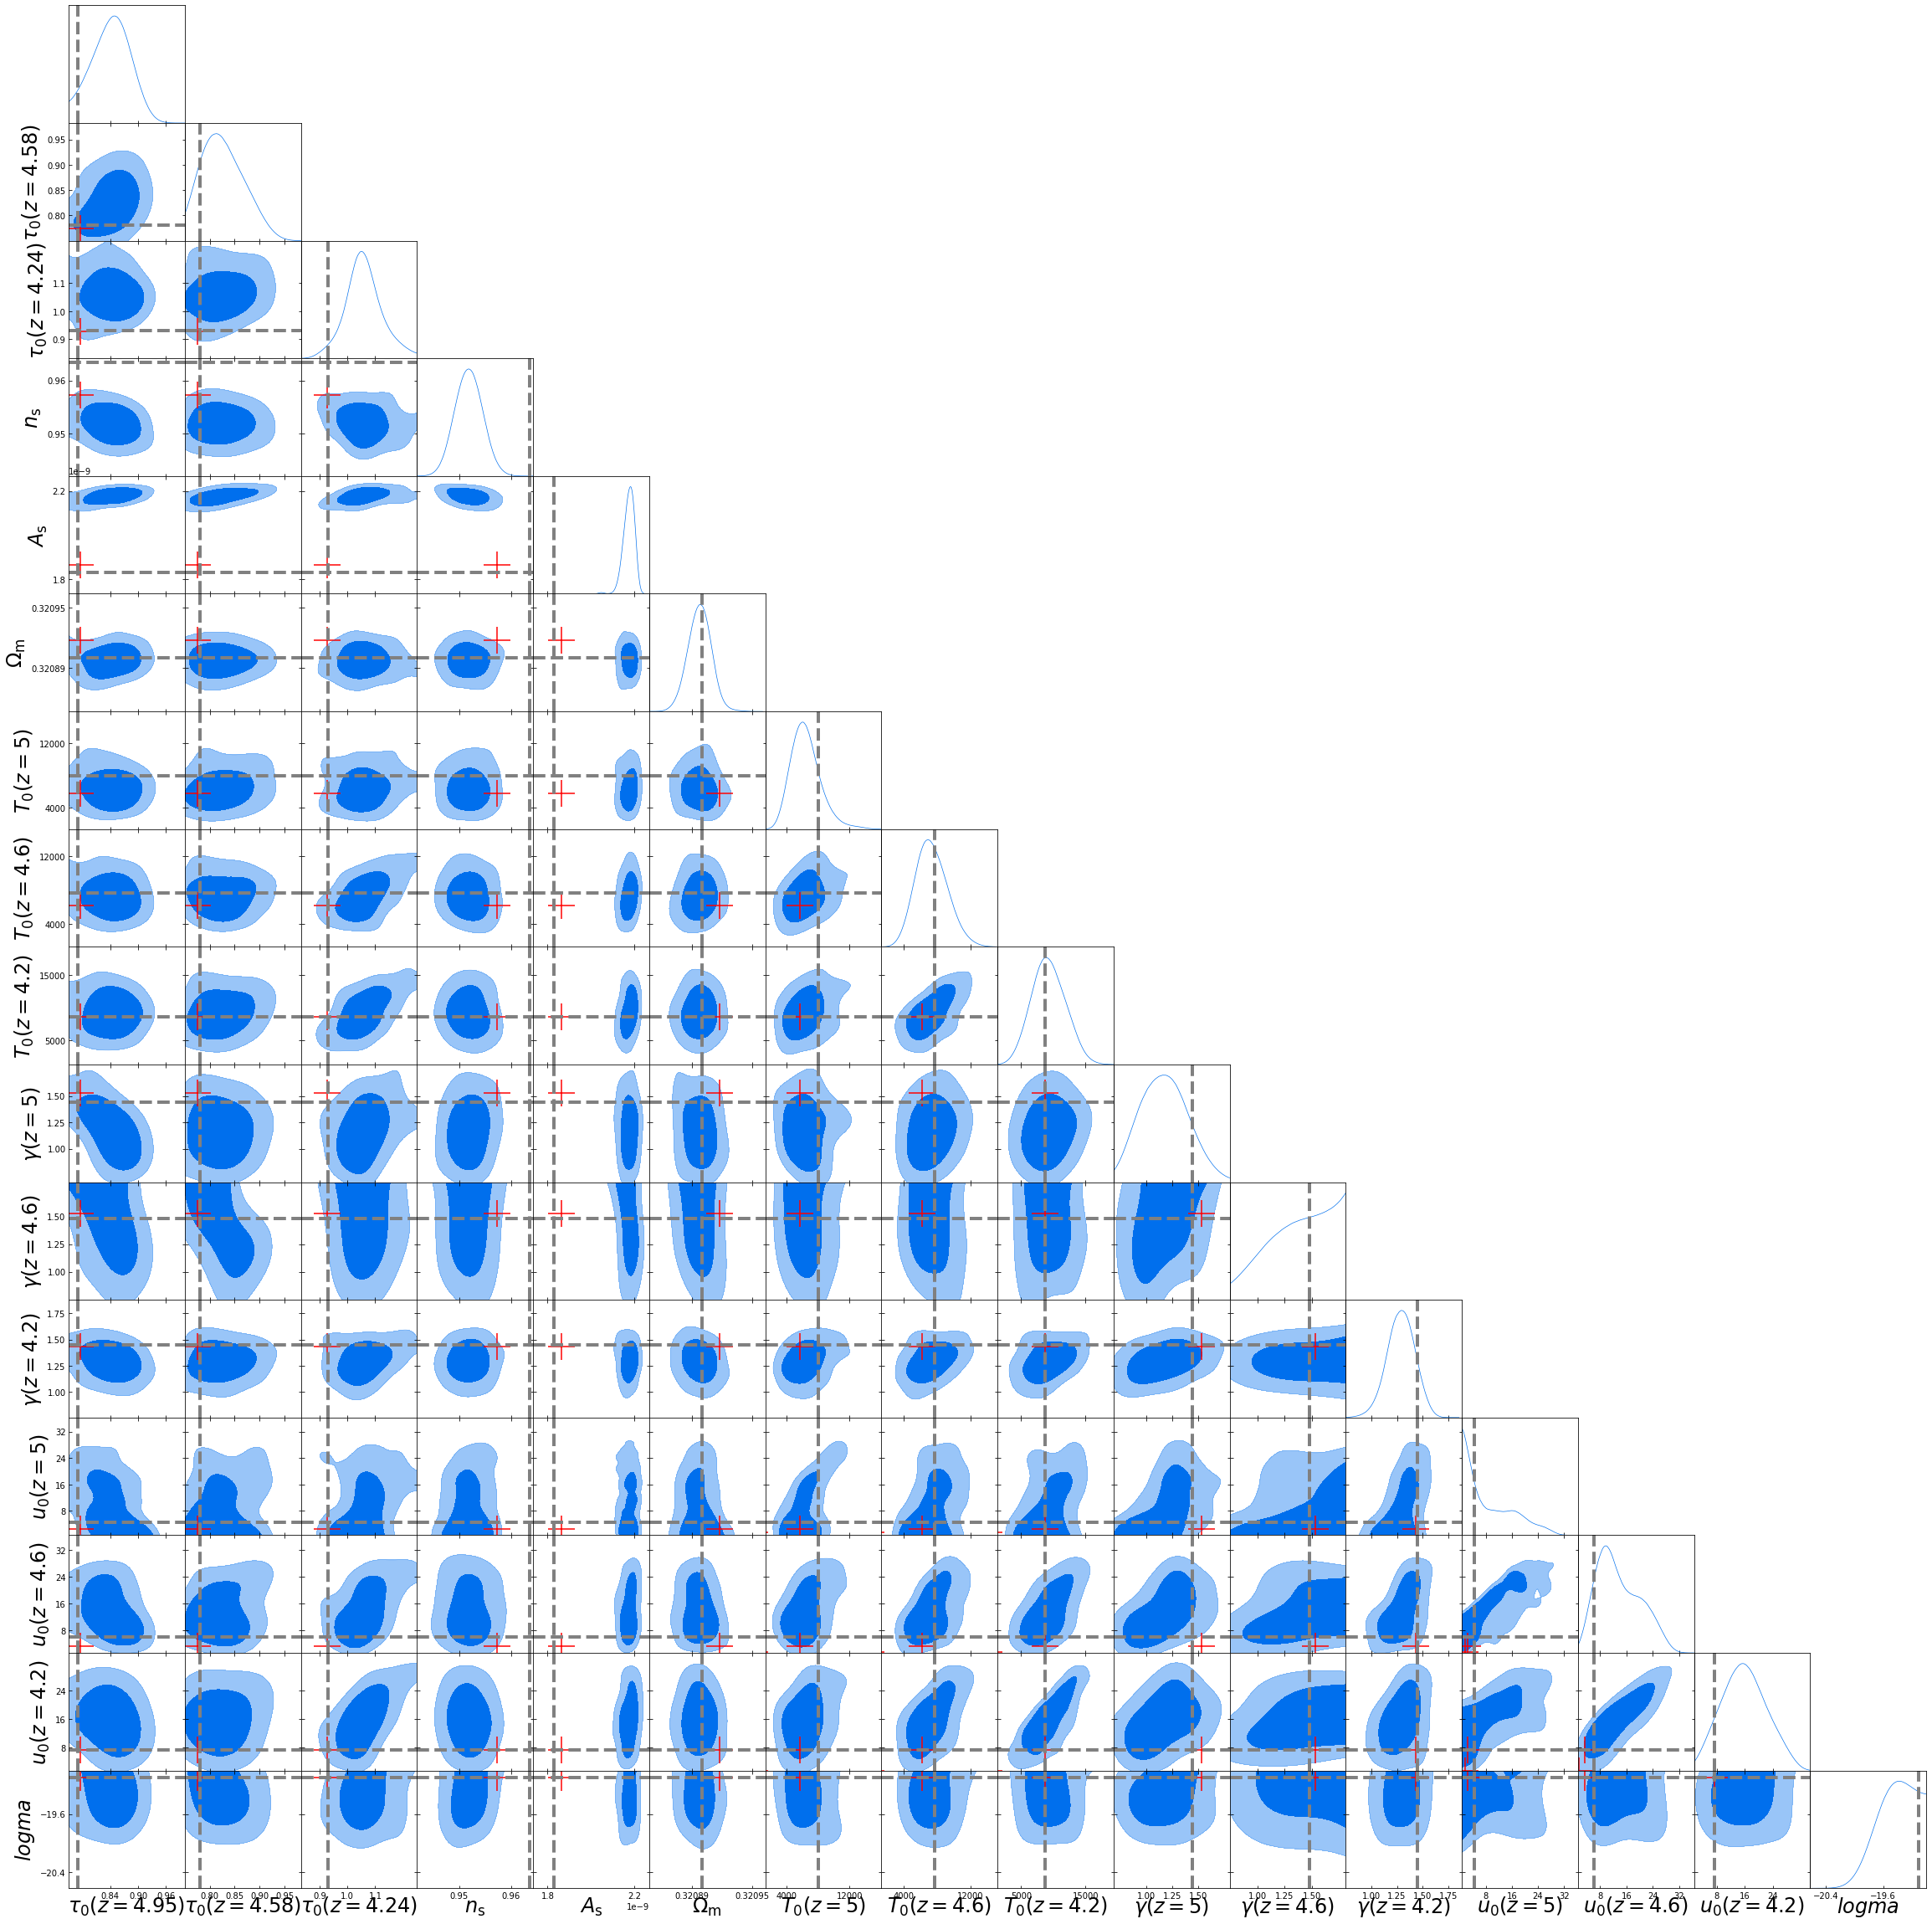

In [15]:
subplot_instance.fig


In [ ]:
#BO-1
Maximum of acquisition function =      fun: -353.914275727603
     jac: array([ 4.55890307e+02,  4.89668190e+02,  2.95751647e+01,  4.49569450e+02,
       -3.77147819e+02,  1.14626398e+04,  1.19608262e+02,  1.13920612e+02,
       -9.70749170e-01, -7.27263853e+01, -7.31309228e+01,  3.79277651e+01,
        2.01726948e+02,  2.63873142e+02,  5.39544658e+00, -3.13192612e+02])
 message: 'Converged (|x_n-x_(n-1)| ~= 0)'
    nfev: 58
     nit: 8
  status: 2
 success: True
       x: array([0.05      , 0.05      , 0.35450285, 0.60230512, 0.51105329,
       0.87024889, 0.30105636, 0.34192525, 0.40767761, 0.75969048,
       0.73606158, 0.66219663, 0.05      , 0.05      , 0.17386334,
       0.96686619])
[ 7.75000000e-01  7.75000000e-01  9.27251427e-01  9.57218987e-01
  1.86436927e-09  3.20917423e-01  5.73440366e+03  6.19803012e+03
  8.67488662e+03  1.52988653e+00  1.52905577e+00  1.43409983e+00
  2.42028785e+00  3.21983473e+00  7.22534864e+00 -1.90994014e+01]
Starting params = [ 7.7000e-01  7.8000e-01  9.3000e-01  9.6350e-01  1.8296e-09  3.2090e-01
  8.0220e+03  7.6510e+03  8.6730e+03  1.4400e+00  1.4800e+00  1.4500e+00
  4.5600e+00  6.1100e+00  7.2400e+00 -1.9100e+01]
